# How much do age and ranking points contribute to predicting a tennis player’s results in the ATP?

Jack Lee Zhang (19192699), Ken Mawer (26207290), Ryan Peng (49203490), Wei Yan Yeong (68951839)

**Introduction**

This dataset describes game results for the top 500 players in the ATP Tour from 2017-2019. Within the dataset, each row is a match between two players and includes information such as their biographical information, ranking, height, and age. According to external research, we found that an average tennis player reaches his peak physical performance between the ages of 27-29.  We ask the following question: how much do age and ranking points contribute to predicting a player’s match results? We are using age and ranking points as explanatory variables to predict results as wins or losses.

**Methods and Results**

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

In [2]:
#First, we read the dataset from a Github URL into R
tennis <- read_csv("https://raw.githubusercontent.com/jlz212/dsci_project/main/atp2017-2019.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [3]:
#By plotting height, age, minutes, winner_hand, and rank_points using ggpairs(),
# we can see which variables have the strongest correlation and are worth exploring
set.seed(1234) #Ensuring consistency
options(repr.plot.height = 15, repr.plot.width = 15)

tennis_winner <- tennis %>%
                    select(winner_rank_points, winner_age, winner_ht) %>%
                    rename(rank_points = winner_rank_points, age = winner_age, height = winner_ht) %>%
                    mutate(results = "W") 
tennis_loser <- tennis %>%
                    select(loser_rank_points, loser_age, loser_ht) %>%
                    rename(rank_points = loser_rank_points, age = loser_age, height = loser_ht) %>%
                    mutate(results = "L")

tennis_data <- rbind(tennis_winner, tennis_loser) %>% #Combining into one table with ranking points, age, and results
                mutate(results = as_factor(results)) %>%
                na.omit() %>%
                sample_n(1500) #Using all observations would overcrowd our plot, so we're sampling 1500

The native format included the columns winner_age,  loser_age, winner_rank_points, and loser_rank_points. Our first step was to use select( ) with the arguments winner_rank_points, winner_age, and winner_ht, then piped rename( ) to turn them into age, height, and ranking points, respectively. Then, using mutate( ), we created a new column “results” and have the output be “W”, since all data from the columns winner_age, winner_ht and winner_rank_points belong to winners. We repeated the same process for losers before using na.omit( ) to skip NA values. In the end, we used rbind( ) and cbind( ) to combine the winner data and loser data into a single output table.

Warning message:
“Removed 144 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 144 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 7 rows containing missing values”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 144 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 7 rows containing missing values”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 144 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 144 rows 

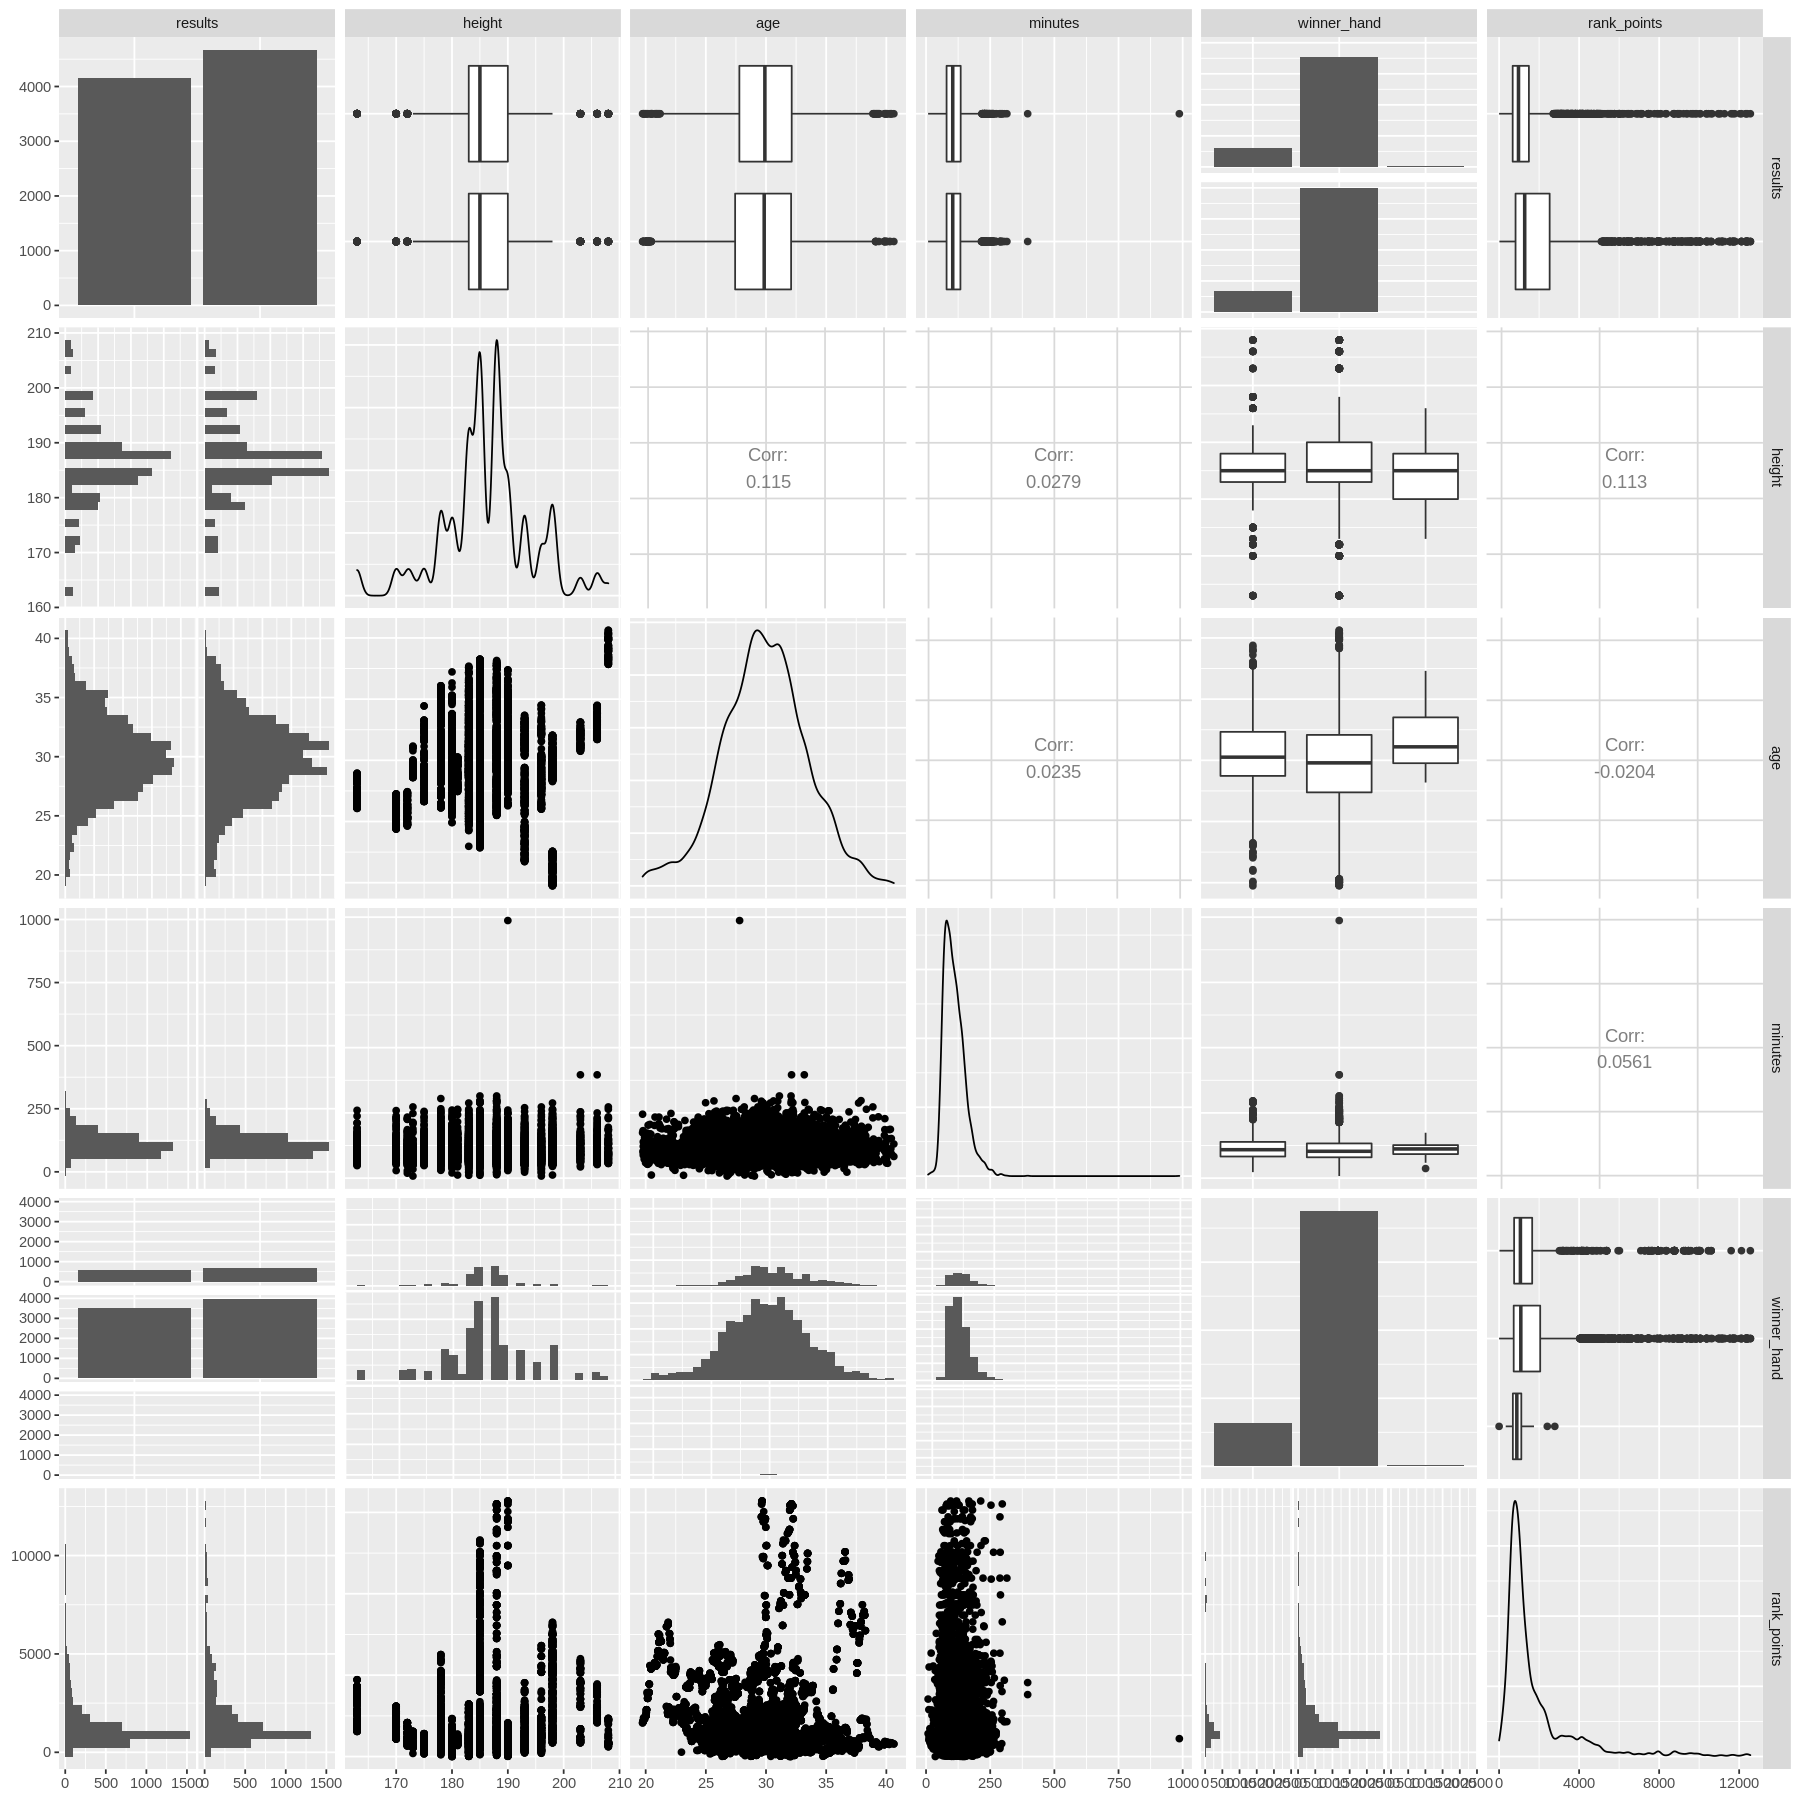

In [4]:
ggpairs_table <- rbind(tennis_winner, tennis_loser) %>%
            cbind(tennis) %>%
            select(results ,height, age, minutes, winner_hand, rank_points) %>%
            drop_na(height)

plot_pairs <- ggpairs_table %>%
                ggpairs()
plot_pairs

Figure 1: ggpairs plot of target variable of results along with possible predictor variables in the dataset

Our target variable "results", doesn't seem to be affected by any of the predictor variables in our ggpairs. However, based on our external research that male players tend to hit their physical peaks in their late 20's, we include age as one of our predictor variables. Our intuition is that rank points is an indicator of players performance, therefore, rank points is our other predictor variable.

In [5]:
#Making the table with our chosen predictor variables: age and rank_points
set.seed(1234) #Ensuring consistency

three_column_table <- rbind(tennis_winner, tennis_loser) %>%
                        select(results, age, rank_points) %>%
                        mutate(results = as_factor(results))
head(three_column_table)
tail(three_column_table)

results,age,rank_points
<fct>,<dbl>,<dbl>
W,29.00479,3590
W,22.88569,1977
W,29.00479,3590
W,33.70568,200
W,22.88569,1977
W,31.88227,1050


results,age,rank_points
<fct>,<dbl>,<dbl>
L,36.26557,9005
L,26.93498,2975
L,23.73990,2235
L,33.68925,667
L,32.59411,2320
L,33.68925,667


Figure 2: tables contain first and last six rows of the observations for age, rank points, and results

In [6]:
#Creating our training and testing datasets
set.seed(1234) #Ensuring consistency
tennis_split <- initial_split(tennis_data, prop = 0.55, strata = results)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

We are splitting our data into training and testing sets. According to the golden rule of machine learning, we should train our model with the training set, otherwise we would "cheat" our accuracy by showing the model our testing set. The prop argument in the initial_split function above designates the percentage of the original dataset that will be split into the training set. As a general rule, the smaller the dataset, the larger the percentage that should be split into the training set. We sampled 1500 observations above into tennis_data, so we know this is relatively large. As such, we have decided to split 55% into the training set. We don't need as much data in the training set because the variance will not be significantly affected. The ultimate goal of this process is to create an unbiased model.

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)

#A table with the total number of observations, mean ranking points, and mean age
num_obs <- nrow(tennis_train)
mean_rank <- mean(tennis_train$rank_points)
mean_age <- mean(tennis_train$age)
missing_data <- sum(is.na(tennis_train))

tennis_train_stats <- c("num_observations", "mean_age", "mean_rank", "missing_data") #strings
values <- c(num_obs, mean_age, mean_rank, missing_data) #variables

stats_analysis_table <- tibble(tennis_train_stats, values)
head(stats_analysis_table)

tennis_train_stats,values
<chr>,<dbl>
num_observations,826.0000
mean_age,29.8046
mean_rank,1840.6743
missing_data,0.0000


Figure 3: table contains the total number of observations, mean age, mean rank points, and number of missing data

"By the end of (2017), (male tennis players' average age) had risen to 28.26. In the last 10 years alone the average ages have risen by 2.67 years among the men," (Cicenia, 2016). We computed the means table above to see if the dataset supports our external research. Within our dataset, the mean age among male players is 29.8, which is similar to what our research provides.

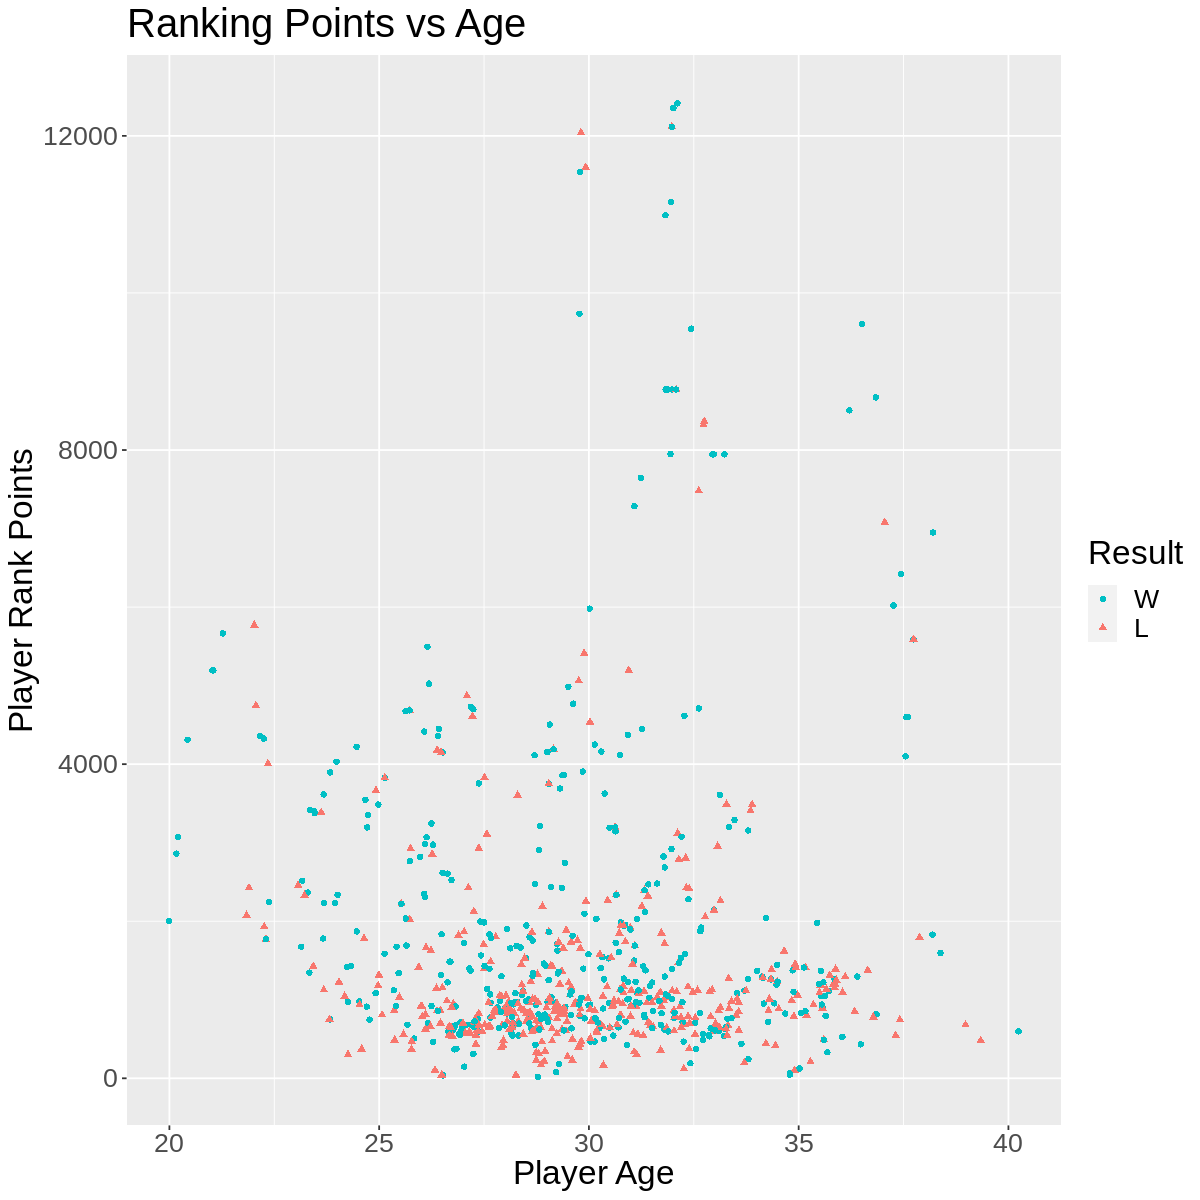

In [8]:
#Visualizing our predictor variables ranking points and age, and how they might predict results using training set
tennis_plot <- tennis_train %>%
    ggplot(aes(x = age, y = rank_points, shape = results, color = results)) +
    geom_point() +
    labs(x = "Player Age", y = "Player Rank Points", shape = "Result", color = "Result", title = "Ranking Points vs Age") +
    theme(text = element_text(size = 20)) +
    scale_color_hue(direction = -1, h.start = 90)
tennis_plot

Figure 4: graph depicting possible relationship between ranking points and age, with points coloured by player results

Based on the scatter plot, we can infer that rank points is a better indicator of results than age. Players with higher rank points (top half of the y-axis) tend to have more wins as indicated by the blue (see legend).

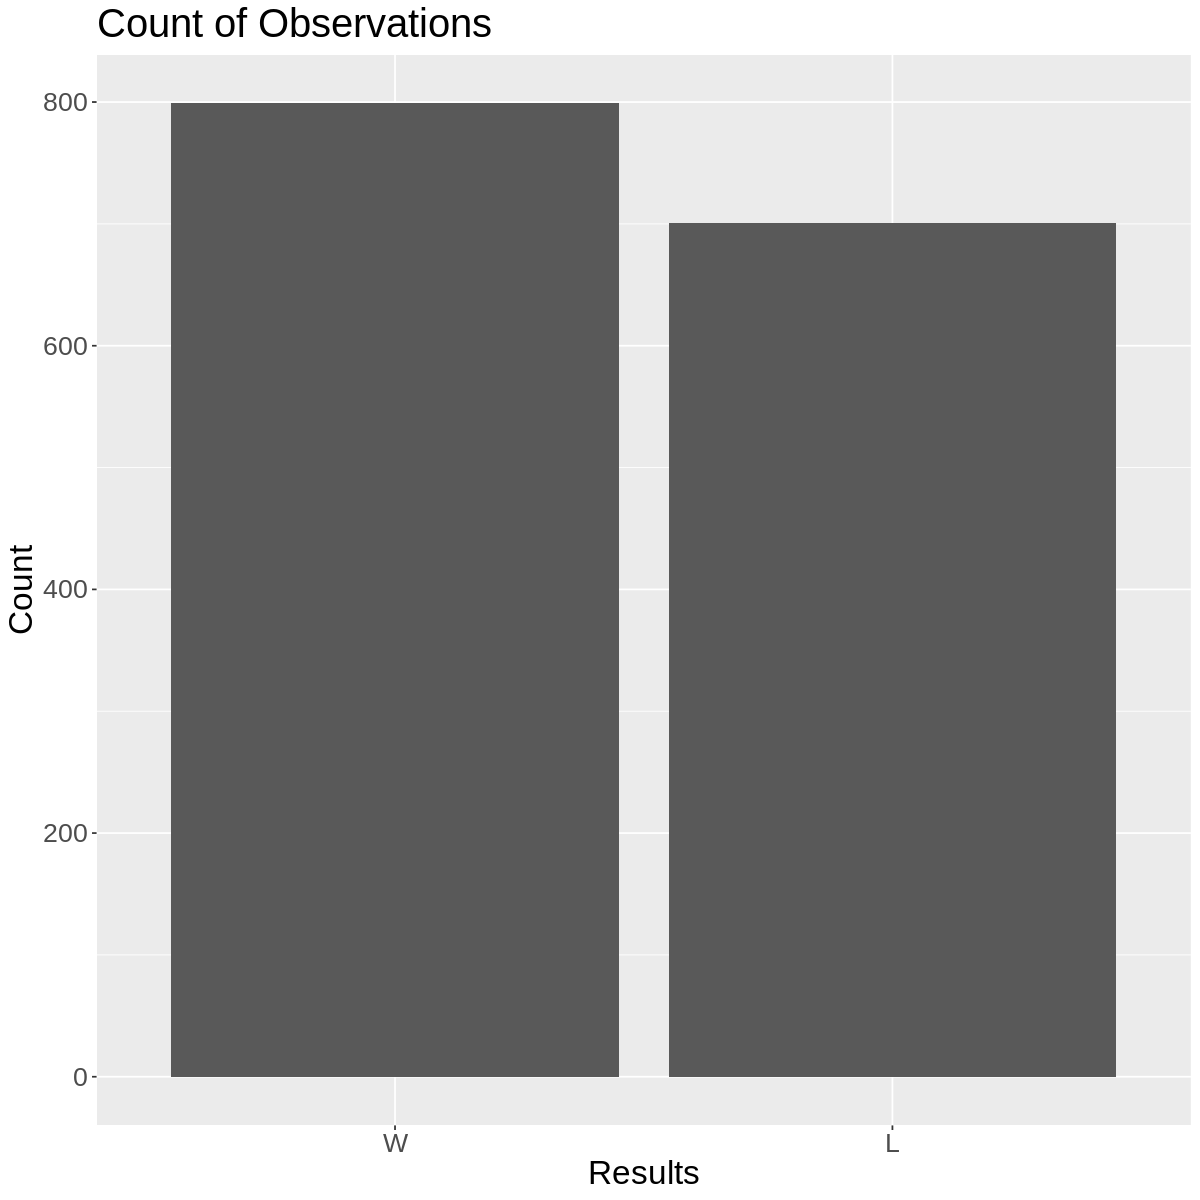

In [9]:
#The distribution of observations into wins and losses to show that there are minimal imbalances
count <- ggplot(tennis_data) +
    geom_bar(mapping = aes(x = results)) +
    labs(x = "Results", y = "Count", title = "Count of Observations") +
    theme(text = element_text(size = 20))
count

Figure 5: bar chart shows the count of winners and losers in training data

The graph above shows that we have a fairly balanced data. An unbalanced data for our classification problem means that one class is a lot more likely to be picked in general even if our pattern suggests otherwise. A balanced dataset therefore provides a higher accuracy model. Since our dataset is fairly balanced, we do not have to over sample one class to maintain the integrity of the accuracy.

**Methods**

We will conduct our data analysis using classification with K-nearest neighbours since we are predicting a categorical class (results) given its quantitative variables (age and ranking points). Age and ranking points will be the predictor variables to classify results.

In [10]:
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = results)

We used the vfold_cv function to perform cross-validation on our original training set with the argument v = 5; splitting our training set into five "folds," with each fold containing 4 training folds and 1 validation fold. This is important because we want a structured splitting procedure that ensures each observation won't appear in the same validation set twice. In other words, we perform cross-validation to reduce bias. The more folds we have, the less bias it creates since there is less dependency on the subset of data that is chosen in the training set.

In [11]:
tennis_recipe <- recipe(results ~ age + rank_points, data = tennis_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

The recipe is used to preprocess, scale, and balance the data. In the arguments for the recipe function, we specified that results is our target variable while age and rank points are our predictor variables. We are using the training set because according to the golden rule of machine learning, the testing data cannot influence the model in any way. Therefore, any wrangling and modifying we do can only affect the training set.

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

We're calling the nearest_neighbor function to generate a model specification for knn classification. We set the neighbors argument to tune() since we don't know the optimal number of neighbors, and the tuning process maximizes the model's performance without overfitting or creating a high variance. The weight_func() argument is set to "rectangular" to signify that each point has equal voting power. The engine is set to "kknn" and mode is set to "classification" to indicate that we are performing k-nearest neighbor classification.

In [13]:
k_lots <- tibble(neighbors = seq(from = 50, to = 500, by = 50))

knn_results <- workflow() %>%
    add_recipe(tennis_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = tennis_vfold, grid = k_lots) %>%
    collect_metrics()
head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
50,accuracy,binary,0.5580942,5,0.012702515,Model01
50,roc_auc,binary,0.5792811,5,0.014194317,Model01
100,accuracy,binary,0.5738299,5,0.016888361,Model02
100,roc_auc,binary,0.5933434,5,0.009811538,Model02
150,accuracy,binary,0.5702008,5,0.013939451,Model03
150,roc_auc,binary,0.6153332,5,0.010269297,Model03


Figure 6: table contains statistics for the quality of the model

We are testing accuracy for K values from K = 50 to K = 500 using intervals of 50. We used a workflow to simplify and chain together multiple data analysis steps; specifically, we skipped the need to call the prep() and bake() functions. Our end result above contains information about our k values including their accuracy and standard error.

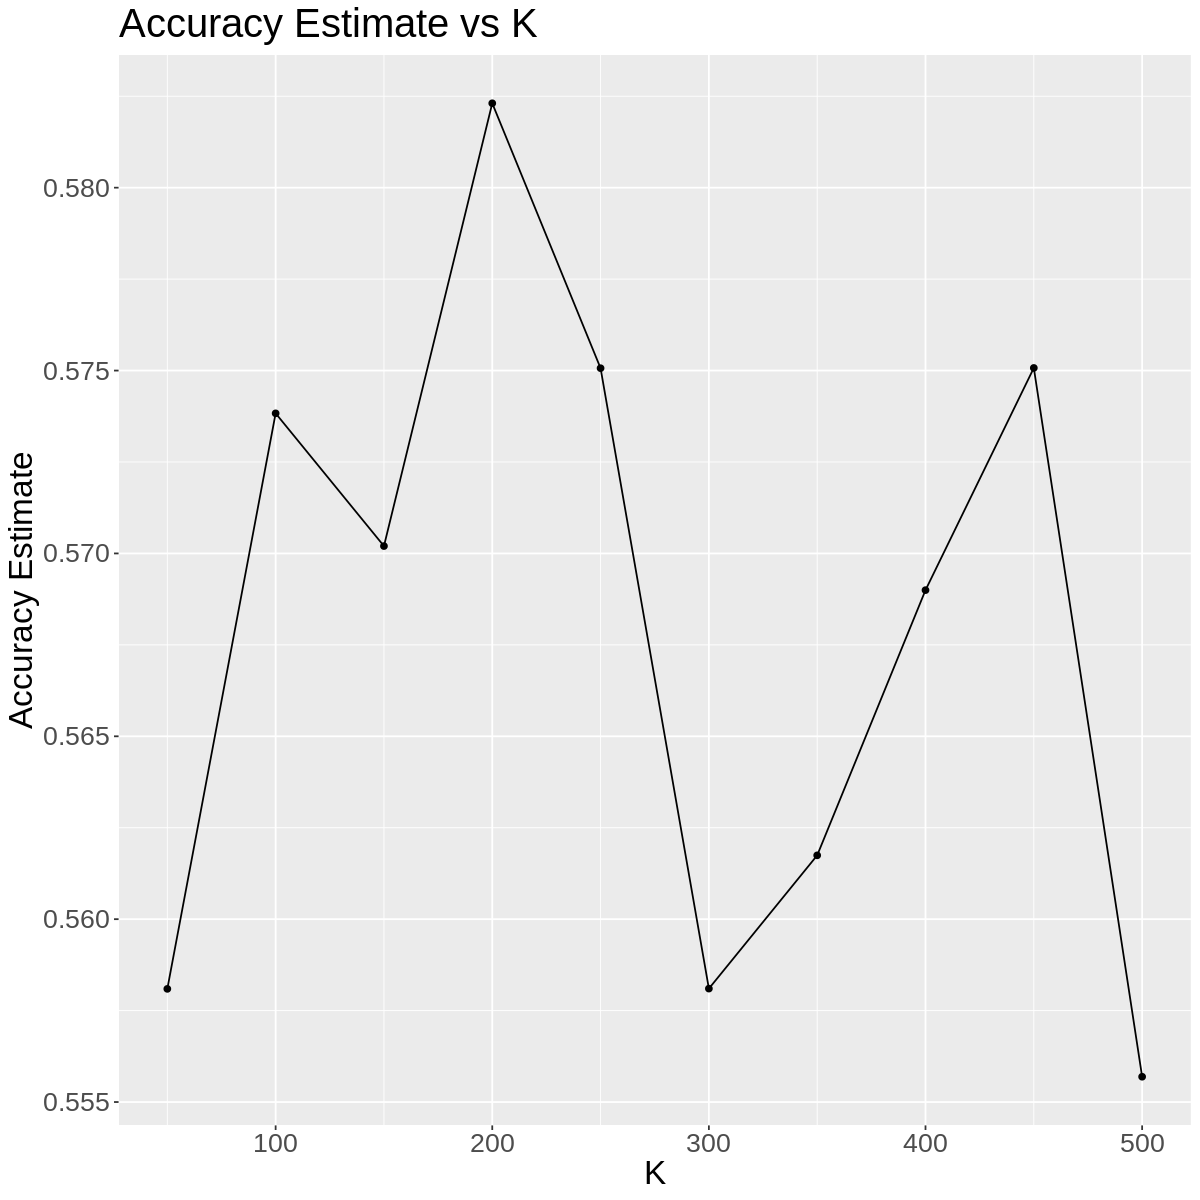

In [14]:
accuracies <- filter(knn_results, .metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "Accuracy Estimate") +
    ggtitle("Accuracy Estimate vs K") +
    theme(text = element_text(size = 20))
accuracies_plot

Figure 7: graph depicting accuracy estimate versus K

We filter for the accuracy rows for each K value for visualization. By plotting K values on the x-axis and accuracy on the y-axis, we see a clear peak at K = 200. Since the y-axis does not vary by much, there is no "perfect" K value; however, our optimal K value will be one in which we get roughly optimal accuracy, where changing it to a nearby K doesn't overly affect accuracy, and where the K is not too big in that it becomes prohibitive. Taking into account these criteria, our optimal K value is 200.

In [15]:
knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 200) %>%
    set_engine("kknn") %>%
    set_mode("classification")

Now that we know the optimal K is 200, we create a new nearest_neighbor model specification using the argument neighbors = 200. We keep the engine and mode the same as we are still performing k-nearest neighbour classification.

In [16]:
knn_fit <- workflow() %>%
    add_recipe(tennis_recipe) %>%
    add_model(knn_best) %>%
    fit(data = tennis_train)

Compared to our previous workflow, we now use the fit function to retrain the classifier instead of the tune_grid function used for cross-validation. Since the model comes from the training data, we are passing the training data named tennis_train into this workflow using the fit function. 

In [17]:
accuracy_prediction <- predict(knn_fit, tennis_test) %>%
    bind_cols(tennis_test)

We use the predict function to predict our labels based on the testing set. We then use bind_cols to add the column of prediction to the original test data in order to create a data frame.

In [18]:
acc <- accuracy_prediction %>% 
    metrics(truth = results, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
acc

[1] 0.5697329

We want to compute the accuracy of our model with K = 200. The metrics function takes our true values from the "truth = results" argument along with our estimate values from the "estimate = .pred_class" argument to output a three column tibble with .metric, .estimator, and .estimate. We filter for the accuracy row before selecting the .estimate column to obtain our accuracy.

With an accuracy of 0.5697, our model is not very accurate in the context of tennis games.

In [19]:
accuracy_prediction <- predict(knn_fit, tennis_test) %>%
    bind_cols(tennis_test)
confusion_matrix <- conf_mat(accuracy_prediction, truth = results, estimate = .pred_class)
confusion_matrix

          Truth
Prediction   W   L
         W 162  93
         L 197 222

Figure 8: the matrix describes what the model predicted, as well as the actual result. For example, if the row is “W” and the column is “L,” it means that the model predicted a win, when the tennis player had actually lost.

Given that a tennis player won, the probability of correctly predicting a win is 45.1%. This is calculated as 162/(162+197), as the number of winning players who the model has correctly predicted as having won, over all the players who have won. Of the players who have won, more than half of those players would have been assumed to have lost, indicating that this model is poor at detecting players who have won. If a tennis player wins, the model is more likely to assume that a tennis player lost rather than won.

Given that a tennis player lost, the probability of correctly predicting a loss is 70.5%. This is calculated as 222/(93+222), losing players who the model correctly predicted as having lost, over all the players who have lost. This describes that if a tennis player loses, then the model will most likely correctly pick this up that the player had indeed lost.

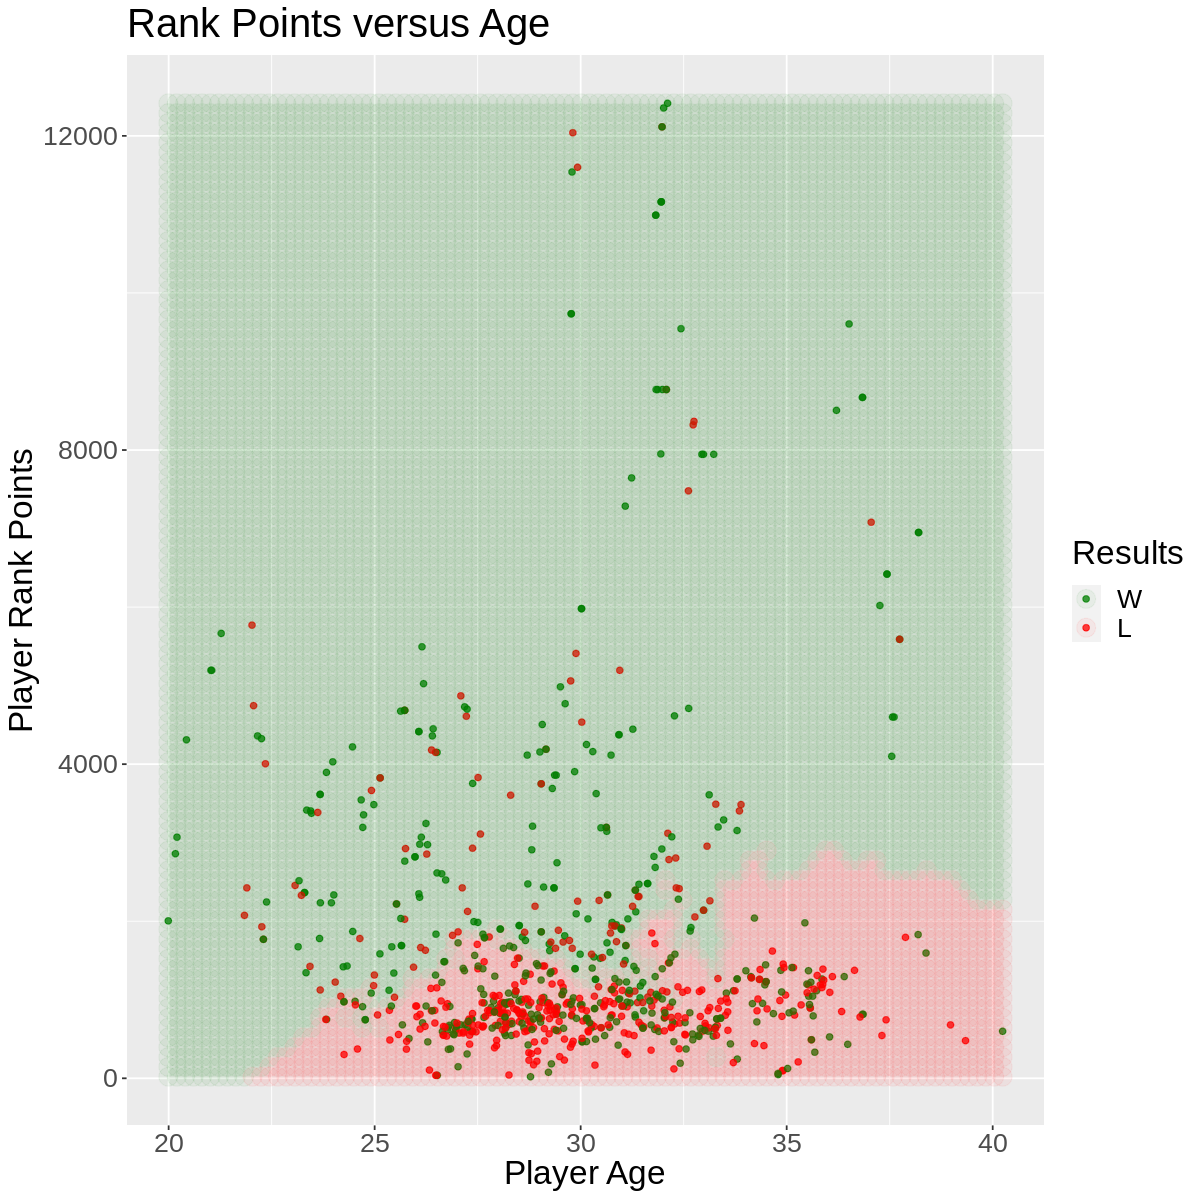

In [20]:
cbPalette <- c("#008000", "#FF0000")

# create the grid of age/rank_points vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$age), max(tennis_train$age), length.out = 100)
smo_grid <- seq(min(tennis_train$rank_points), max(tennis_train$rank_points), length.out = 100)
asgrid <- as_tibble(expand.grid(age=are_grid, rank_points=smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Class = .pred_class)

# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points 
wkflw_plot <-
  ggplot() +
    geom_point(data = tennis_train, mapping = aes(x = age, y = rank_points, color = results), alpha=0.75) +
    geom_point(data = prediction_table, mapping = aes(x = age, y = rank_points, color = Class), alpha=0.05, size=5.)+
    labs(color = "Results") +
    scale_color_manual(labels = c("W", "L"), values = cbPalette) +
    labs(x = "Player Age", y = "Player Rank Points") +
    ggtitle("Rank Points versus Age") +
    theme(text = element_text(size = 20))
wkflw_plot

Figure 9: graph shaded by decision boundaries depicting possible relationship between ranking points and age, with points coloured by player results

The final graph describes that players with higher ranking points are more likely to win, as expected. In addition, it also describes that as the players age, players are generally more likely to lose given the same number of ranking points. This could suggest that people will continue to play tennis until they are eliminated for losing and become discouraged, or that the ranking is not adjusted to account for deterioration from ageing. Thus, the model provides a crude indicator of what tennis players tend to win or lose.

**Discussion** 

*Findings Summary*

Based on our results, our prediction model appears to have a low to moderate accuracy, which indicates that age and rank points may not be good predictors of tennis game results. However, the decision boundaries on the classification scatterplot has illustrated that players with higher rank points are more likely to win compared to players with lower rank points. In contrast to our hypothesis, there are also more losses (red shading) as the player's age increases. The proportion of red-shaded area is greater on the right side of the scatterplot.

*Findings Expectations*

Our model tells us that using only age and rank points as predictor variables will not procure a high accuracy when predicting the results of a game. This is not particularly surprising, as tennis is a multifaceted game with many factors ultimately contributing to a player’s success. By limiting ourselves to these two factors, we ignore other circumstances that may influence a player’s performance, such as their height and number of years played, or external factors like the court surface condition and whether the player is battling jet lag.

*Findings Impact*

Our findings would not have a significant impact as our prediction model has a low accuracy. However, our model does provide us with a general trend that is specific to this data set; players with the most rank points tend to be between age 30 and 35, and players with age greater than 35 have a higher chance of losing (according to the plot above).

*Future Question*

A question that might arise is whether it is possible to construct a model that will accurately predict the results of tennis matches. From our model, we know that using two predictor variables will yield a low accuracy; however, is there a way to encapsulate all the factors that would impact a tennis match? Constructing such a model would require further research and expertise in the field of tennis.

**References**

Cicenia, M. ( June 4, 2016)  The numbers prove it: Tennis players are getting older. Tennishead. 
Retrieved from  https://tennishead.net/the-numbers-prove-it-tennis-players-are-getting-older/


Cicenia, M. (Mar 20, 2017)  Why 30 Is the New 24 in Professional Tennis. Last Word on Sports. 
Retrieved from https://lastwordonsports.com/2016/06/04/30-new-24-professional-tennis/